In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset()

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [5]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(256, 256, 3),
                                              include_top=False,
                                              weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Заморозим слои, чтобы веса не обновлялись во время обучения:

In [6]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [7]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        81,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,646,760 (90.21 MB)

 Trainable params: 81,960 (320.16 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Начнем обучение модели с замороженными нижними слоями:

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [10]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/resnet_50_v2.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [11]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713771616.652671  105541 service.cc:145] XLA service 0x78dd1c10f790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713771616.652729  105541 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-22 14:40:16.810983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 14:40:17.701213: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/433 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.0000e+00 - loss: 4.2667   

I0000 00:00:1713771624.475180  105541 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 62s 115ms/step - accuracy: 0.1205 - loss: 3.5060 - val_accuracy: 0.3805 - val_loss: 2.3116
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.3818 - loss: 2.2315 - val_accuracy: 0.5030 - val_loss: 1.8509
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.4882 - loss: 1.8083 - val_accuracy: 0.5571 - val_loss: 1.6334
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.5519 - loss: 1.5886 - val_accuracy: 0.5858 - val_loss: 1.5113
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.5931 - loss: 1.4476 - val_accuracy: 0.6104 - val_loss: 1.4099
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.6264 - loss: 1.3360 - val_accuracy: 0.6239 - val_loss: 1.3456
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.6531 - loss: 1.2564 - val_accuracy: 0.6401 - val_loss: 1.2941
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.6686 - loss: 1.1928 - val

Так как число параметров в нижних слоях огромно (более 21 миллиона), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [12]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7085 - loss: 1.0200


In [13]:
results

[1.040906310081482, 0.7046371102333069]

Посомтрим несколько предсказаний:

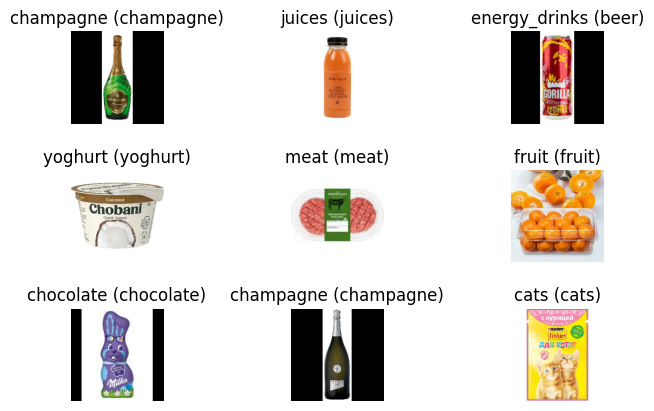

In [14]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-22 14:58:40.435614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


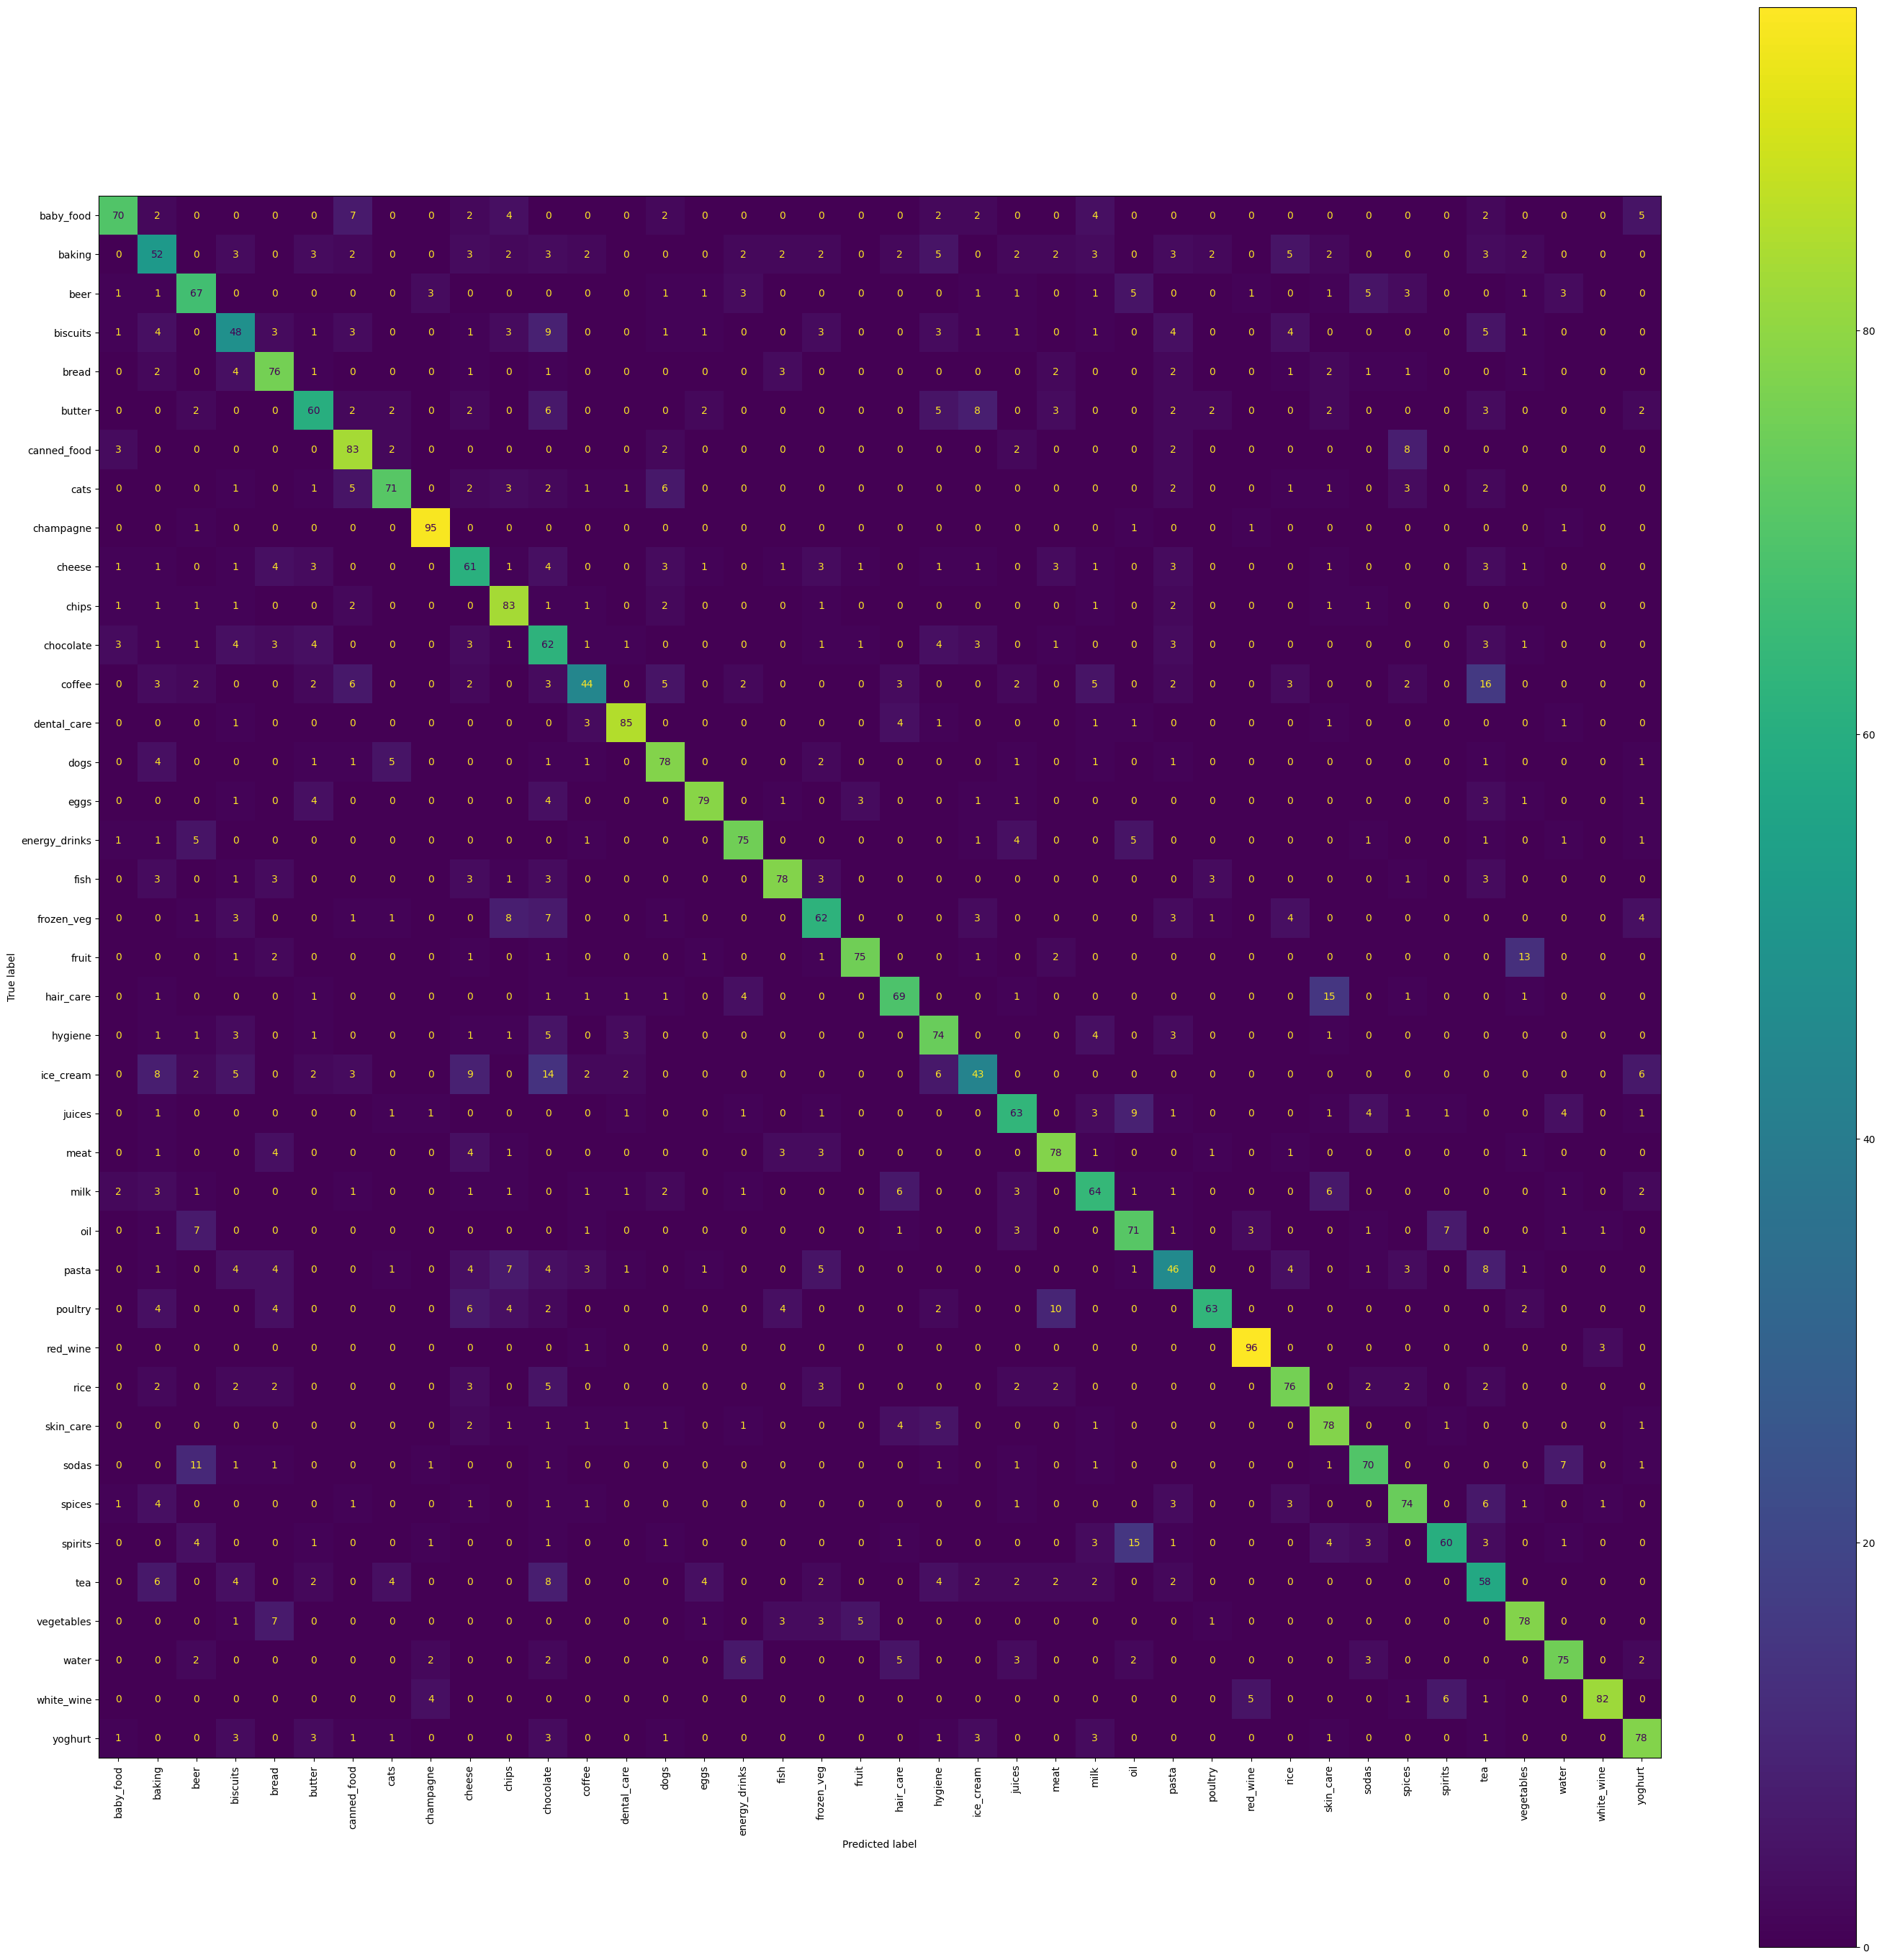

In [15]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [16]:
model.save('ready_models/resnet_50_v2.keras')

In [17]:
import json

with open('models_histories/resnet_50_v2.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

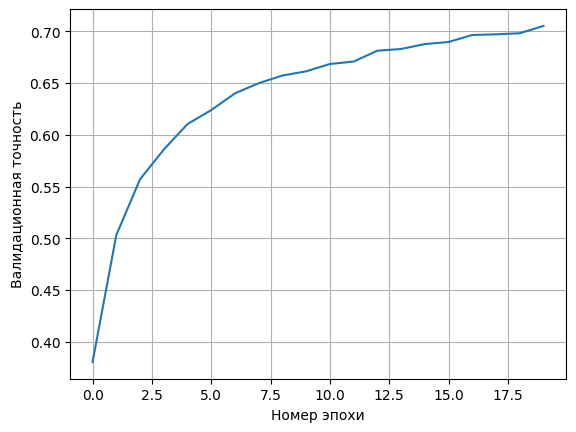

In [18]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')